In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## 개, 고양이들의 class activation map에서 얼굴을 주로 보는 경향이 있다는 것을 차용하여 학습

#데이터셋 준비(전과 똑같다)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/images.tar.gz

In [4]:
!tar -xf /content/gdrive/My\ Drive/Colab\ Notebooks/Oxford-IIIT/annotations.tar.gz

In [5]:
cur_dir = os.getcwd()
image_dir = os.path.join(cur_dir,'images')
#경로는 content 바로 아래 풀려있다

In [6]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']#확장자가 jpg인거만
print(len(image_files))#7390개

7390


In [7]:
#image file중 channel이 3이 아니면 삭제
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    image_mode = image.mode
    
    if image_mode != 'RGB':
        print(image_file, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(image_path)

Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_167.jpg P
(275, 183)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_145.jpg P
(188, 216)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Egyptian_Mau_139.jpg P
(250, 350)


In [8]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))#7378개

7378


In [9]:
#집합으로 이름을 정리
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+','',file_name)#뒤에 숫자 pug_111같은거에서 삭제
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [10]:
#정렬
class_list.sort()
class2idx = {cls:idx for idx,cls in enumerate(class_list)}#딕셔너리로 만들어서 one-hot encoding쉽게하자

In [11]:
train_dir=os.path.join(cur_dir,'train')
val_dir=os.path.join(cur_dir,'validation')

os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)

In [12]:
image_files.sort()

In [13]:
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [14]:
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+','',file_name)
    if class_name == previous_class:
        cnt += 1
    else:
        cnt = 1
    if cnt <= 160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir,image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name

In [15]:
train_images = os.listdir(train_dir)#5920
val_images = os.listdir(val_dir)#1458
print(len(train_images),len(val_images))

5920 1458


In [16]:
IMG_SIZE = 224

In [17]:
#tfreord저장할곳
tfr_dir = os.path.join(cur_dir,'tfrecord')
os.makedirs(tfr_dir,exist_ok=True)

tfr_train_dir=os.path.join(tfr_dir,'cls_train.tfr')
tfr_val_dir=os.path.join(tfr_dir,'cls_val.tfr')

In [18]:
#tfrecord writer생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [19]:
#tensorflow 듀토리얼에서 긁어옴.
# https://www.tensorflow.org/tutorials/load_data/tfrecord
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [20]:
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
    train_path = os.path.join(train_dir, train_file)
    image = Image.open(train_path)
    image = image.resize((IMG_SIZE,IMG_SIZE))
    bimage = image.tobytes()

    file_name = os.path.splitext(train_file)[0]
    class_name = re.sub('_\d+','',file_name)
    class_num = class2idx[class_name]

    if file_name[0].islower():#개
        bi_cls_num = 0
    else:
        bi_cls_num = 1
    example = tf.train.Example(features = tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(class_num),
        'bi_cls_num':_int64_feature(bi_cls_num)
    }))
    writer_train.write(example.SerializeToString())
    n_train += 1

writer_train.close()
print(n_train)

5920


In [21]:
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
    val_path = os.path.join(val_dir, val_file)
    image = Image.open(val_path)
    image = image.resize((IMG_SIZE,IMG_SIZE))
    bimage = image.tobytes()

    file_name = os.path.splitext(val_file)[0]
    class_name = re.sub('_\d+','',file_name)
    class_num = class2idx[class_name]

    if file_name[0].islower():#개
        bi_cls_num = 0
    else:#고양이
        bi_cls_num = 1
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(class_num),
        'bi_cls_num':_int64_feature(bi_cls_num)
    }))
    writer_val.write(example.SerializeToString())
    n_val += 1

writer_val.close()
print(n_val)

1458


In [22]:
!ls -l $tfr_dir

total 1085164
-rw-r--r-- 1 root root 891611200 Aug 19 06:25 cls_train.tfr
-rw-r--r-- 1 root root 219589380 Aug 19 06:26 cls_val.tfr


#Classification

In [23]:
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN/N_BATCH#1480
validation_steps = int(np.ceil(N_VAL/N_BATCH))#37

In [24]:
#tfrecord를 data로 parsing
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)

    return image, label

In [25]:
#train_dataset
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [26]:
#val_dataset
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

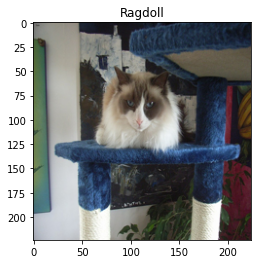

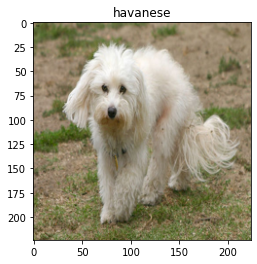

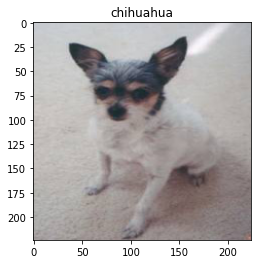

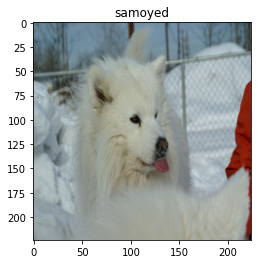

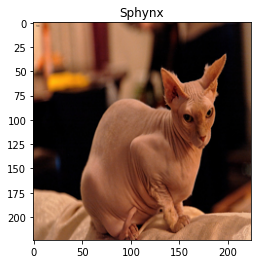

In [27]:
#잘 되었니..?
for image, label in train_dataset.take(5):
    plt.imshow(image[0])#각 배치의 첫번째꺼를 보자
    title = class_list[label[0].numpy()]
    plt.title(title)
    plt.show()

In [28]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [29]:
#functional api를 쓴 이유는 cam에서 feature랑 weight를 가져와야되는데 이게 좋다.
def MyModel():
    mobilenetv2 = MobileNetV2(weights='imagenet',include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    gap = GlobalAveragePooling2D()(mobilenetv2.output)
    output = Dense(N_CLASS, activation = 'softmax', name = 'output_layer')(gap)
    return keras.Model(inputs=mobilenetv2.input, outputs = output)

In [30]:
model = MyModel()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)

model.compile(optimizer = keras.optimizers.Adam(lr_schedule),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________________

In [31]:
history = model.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_dataset,
    validation_steps = validation_steps
)
#val set에 문제가 있나??확인해볼것 초반 loss랑 acc가 똥이다.

# optimizer를 adam으로 고쳤따. ㄹㅇ adam 짱짱맨

Epoch 1/20
148/148 [==============================] - 69s 465ms/step - loss: 1.1712 - accuracy: 0.7106 - val_loss: 0.6430 - val_accuracy: 0.7888
Epoch 2/20
148/148 [==============================] - 68s 459ms/step - loss: 0.2382 - accuracy: 0.9394 - val_loss: 0.4624 - val_accuracy: 0.8484
Epoch 3/20
148/148 [==============================] - 67s 456ms/step - loss: 0.1090 - accuracy: 0.9760 - val_loss: 0.4594 - val_accuracy: 0.8484
Epoch 4/20
148/148 [==============================] - 68s 459ms/step - loss: 0.0518 - accuracy: 0.9922 - val_loss: 0.3893 - val_accuracy: 0.8724
Epoch 5/20
148/148 [==============================] - 67s 455ms/step - loss: 0.0285 - accuracy: 0.9983 - val_loss: 0.3261 - val_accuracy: 0.8848
Epoch 6/20
148/148 [==============================] - 68s 461ms/step - loss: 0.0183 - accuracy: 0.9997 - val_loss: 0.3168 - val_accuracy: 0.8889
Epoch 7/20
148/148 [==============================] - 68s 457ms/step - loss: 0.0133 - accuracy: 0.9997 - val_loss: 0.2981 - val_ac

#Class Activation Map 만들기


In [32]:
target_fmap = model.get_layer(name = 'out_relu').output#gap의 input을 가져온다!!!
new_model = keras.models.Model(model.input, target_fmap)#out_relu까지의 layer를 가지는 모델

In [33]:
weights = model.get_layer(name = 'output_layer').get_weights()[0]#weight는 0번, bias는 1번인데 weight만 필요하다 지금은

In [34]:
weights.shape#1280->37

(1280, 37)

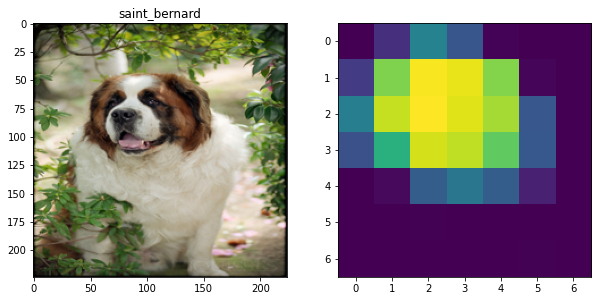

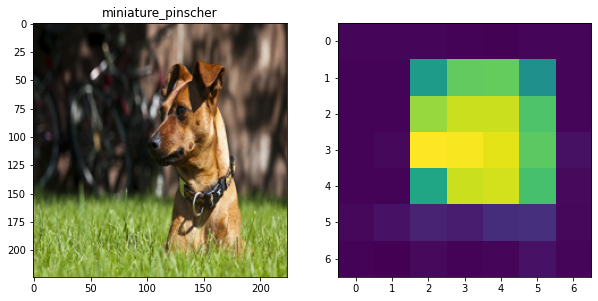

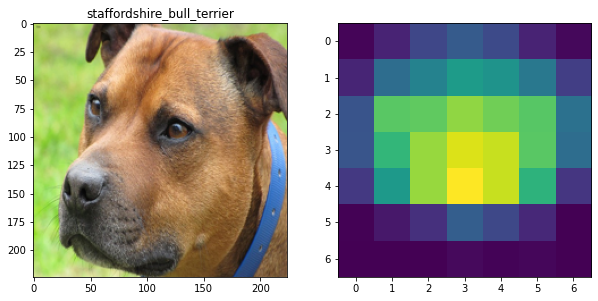

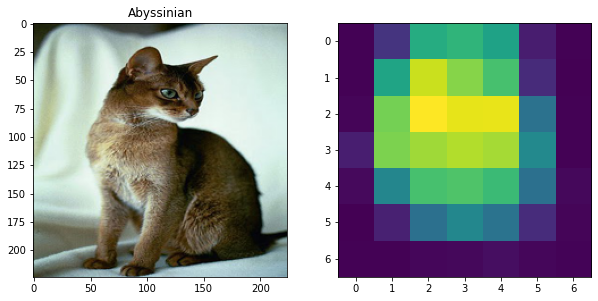

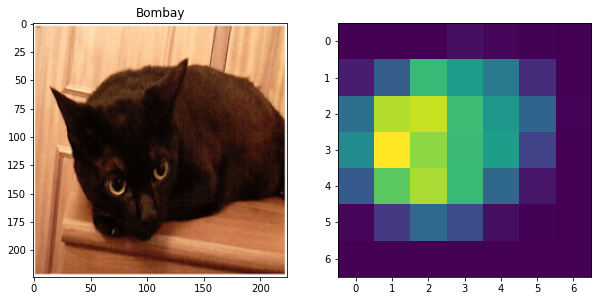

In [35]:
# 왼쪽엔 이미지 원본, 오른쪽엔 cam
for images, labels in val_dataset.take(5):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(images[0])
    prediction = model.predict(images)
    #ex 5번 class다 하면 거기 달려있는 애만 필요하다.
    pred_class = np.argmax(prediction[0],-1)
    title = class_list[pred_class]
    plt.title(title)

    plt.subplot(1,2,2)
    fmap = new_model(images)
    #여기서 weight를 곱해준다.
    weights_cam = weights[:,pred_class]
    camsum = np.zeros((7,7))
    #각channel을 각 weight에 곱해서 camsum
    for i in range(1280):
        camsum += weights_cam[i]*fmap[0,:,:,i]
    camsum = camsum / 1280
    plt.imshow(camsum)

    plt.show()
    #얼굴을 많이 보긴한다.

#고양이와 개로 classification하기

In [54]:
N_CLASS = 2

In [40]:
#파싱하는 function을 바꿔주고
def _parse_function2(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)

    return image, bi_cls_label

In [41]:
#train_dataset
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function2, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [42]:
#val_dataset
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function2, num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

tf.Tensor(0, shape=(), dtype=int64)


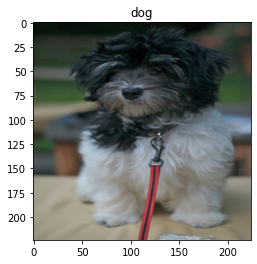

tf.Tensor(0, shape=(), dtype=int64)


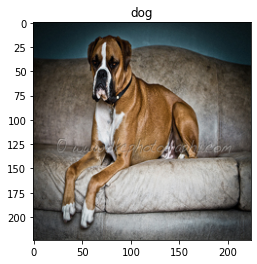

tf.Tensor(1, shape=(), dtype=int64)


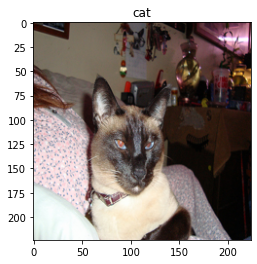

tf.Tensor(0, shape=(), dtype=int64)


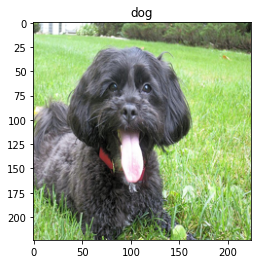

tf.Tensor(1, shape=(), dtype=int64)


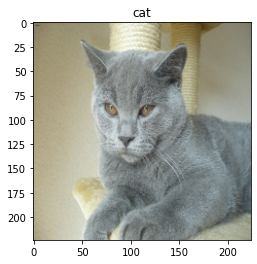

In [50]:
#잘 되었니..?
for image, bi_class_label in train_dataset.take(5):
    plt.imshow(image[0])#각 배치의 첫번째꺼를 보자
    print(bi_class_label[0])
    if bi_class_label[0] == 0:
        title = 'dog'
    else:
        title = 'cat'
    plt.title(title)
    plt.show()

In [51]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [55]:
def MyModel2():
    mobilenetv2 = MobileNetV2(weights='imagenet',include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    gap = GlobalAveragePooling2D()(mobilenetv2.output)
    output = Dense(N_CLASS, activation = 'softmax', name = 'output_layer')(gap)
    return keras.Model(inputs=mobilenetv2.input, outputs = output)

In [56]:
model2 = MyModel2()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)

model2.compile(optimizer = keras.optimizers.Adam(lr_schedule),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [61]:
history = model2.fit(
    train_dataset,
    epochs = N_EPOCHS,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_dataset,
    validation_steps = validation_steps
)

Epoch 1/20
148/148 [==============================] - 70s 474ms/step - loss: 0.0663 - accuracy: 0.9745 - val_loss: 0.0184 - val_accuracy: 0.9952
Epoch 2/20
148/148 [==============================] - 68s 459ms/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.0195 - val_accuracy: 0.9952
Epoch 3/20
148/148 [==============================] - 68s 461ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.0627 - val_accuracy: 0.9808
Epoch 4/20
148/148 [==============================] - 68s 458ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.0185 - val_accuracy: 0.9945
Epoch 5/20
148/148 [==============================] - 69s 464ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0190 - val_accuracy: 0.9945
Epoch 6/20
148/148 [==============================] - 68s 460ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0200 - val_accuracy: 0.9952
Epoch 7/20
148/148 [==============================] - 69s 463ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0153 - val_ac

# Class Activation Map 만들기

In [62]:
target_fmap2 = model2.get_layer(name = 'out_relu').output#gap의 input을 가져온다!!!
new_model2 = keras.models.Model(model2.input, target_fmap2)#out_relu까지의 layer를 가지는 모델

In [63]:
weights2 = model2.get_layer(name = 'output_layer').get_weights()[0]#weight는 0번, bias는 1번인데 weight만 필요하다 지금은

In [64]:
# binary classification하니까
weights2.shape

(1280, 2)

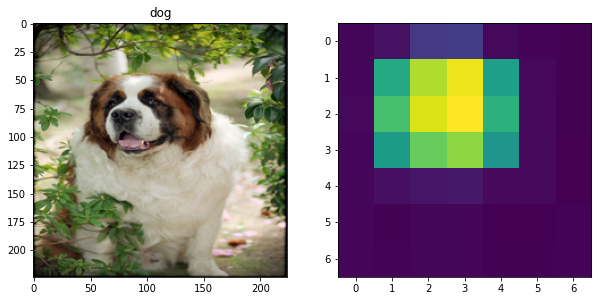

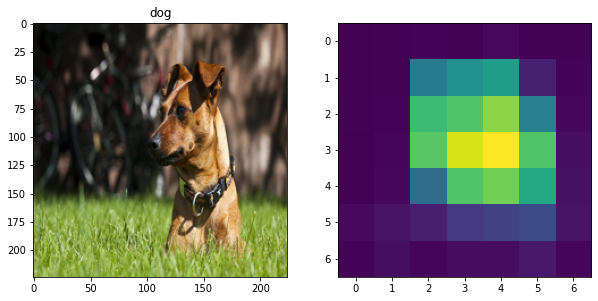

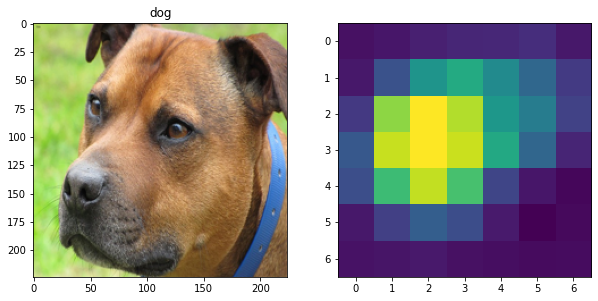

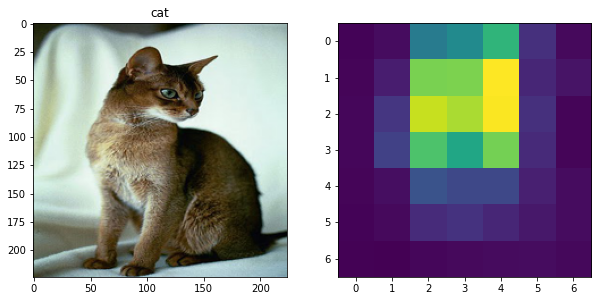

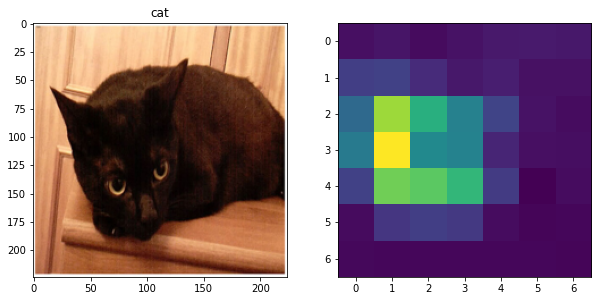

In [65]:
# 왼쪽엔 이미지 원본, 오른쪽엔 cam
for images, labels in val_dataset.take(5):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(images[0])
    prediction = model2.predict(images)
    pred_class = np.argmax(prediction[0],-1)
    if labels[0] == 0:
        title = 'dog'
    else:
        title = 'cat'
    plt.title(title)

    plt.subplot(1,2,2)
    fmap = new_model2(images)
    #여기서 weight를 곱해준다.
    weights_cam = weights2[:,pred_class]
    camsum = np.zeros((7,7))
    #각channel을 각 weight에 곱해서 camsum
    for i in range(1280):
        camsum += weights_cam[i]*fmap[0,:,:,i]
    camsum = camsum / 1280
    plt.imshow(camsum)

    plt.show()
    #종 분류보다 얼굴을 많이 보긴한다.

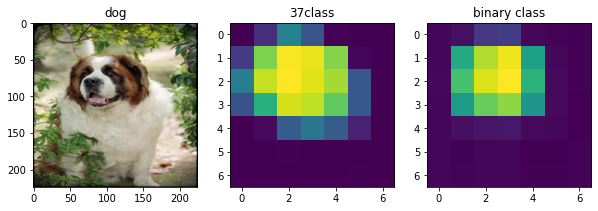

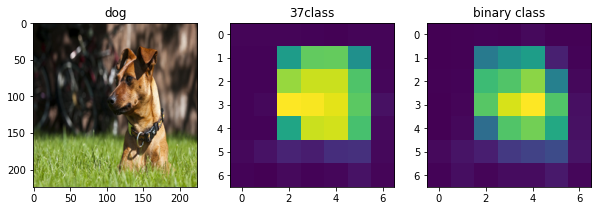

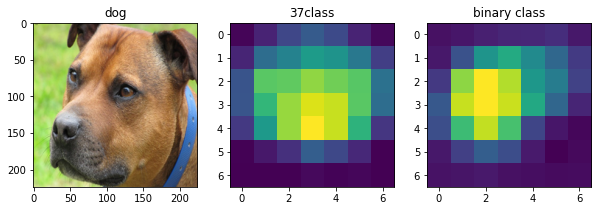

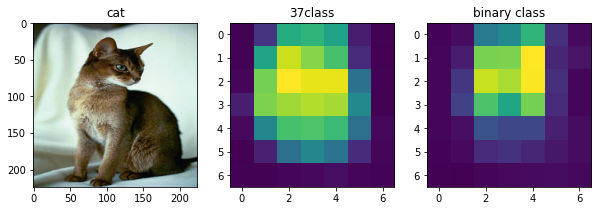

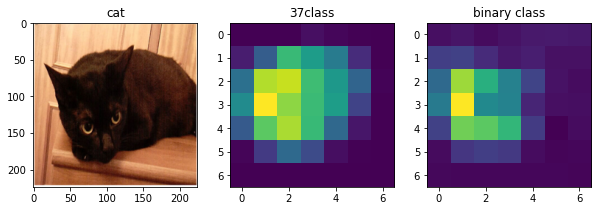

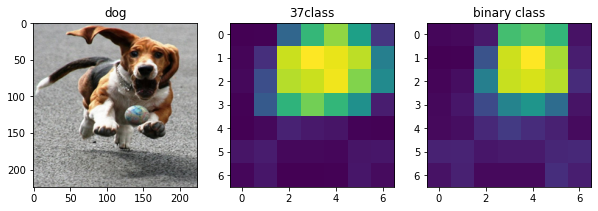

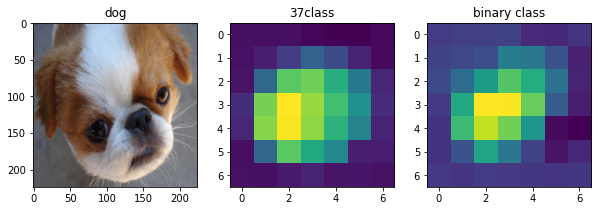

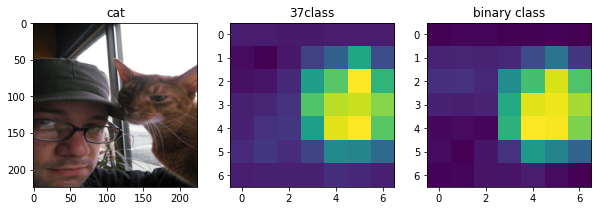

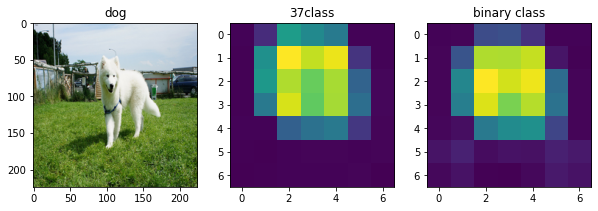

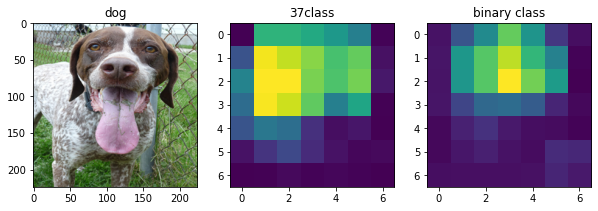

In [72]:
#10장을 model, model2둘다 해서 비교해보자
for images, labels in val_dataset.take(10):
    plt.figure(figsize=(10,5))

    plt.subplot(1,3,1)
    if labels[0] == 0:
        title = 'dog'
    else:
        title = 'cat'
    plt.title(title)
    plt.imshow(images[0])

    plt.subplot(1,3,2)
    prediction1 = model.predict(images)
    pred_class1 = np.argmax(prediction1[0],-1)
    fmap1 = new_model(images)
    weights1 = model.get_layer(name='output_layer').get_weights()[0]
    weights_cam1 = weights1[:,pred_class1]
    camsum1 = np.zeros((7,7))
    for i in range(1280):
        camsum1 += weights_cam1[i]*fmap1[0,:,:,i]
    camsum1 /= 1280
    plt.title('37class')
    plt.imshow(camsum1)

    plt.subplot(1,3,3)
    prediction2 = model2.predict(images)
    pred_class2 = np.argmax(prediction2[0],-1)
    fmap2 = new_model2(images)
    weights2 = model2.get_layer(name = 'output_layer').get_weights()[0]
    weights_cam2 = weights2[:,pred_class2]
    camsum2 = np.zeros((7,7))
    for i in range(1280):
        camsum2 += weights_cam2[i]*fmap2[0,:,:,i]
    camsum2 /= 1280
    plt.title('binary class')
    plt.imshow(camsum2)

    plt.show()

# 좀 더 얼굴만 보는걸 확인할 수 있다.
# 4번째가 가장 좋은 예시이다.